# Task #1 

Training an RBM on H$_2$ data for differnt radii is shown here. 

Imports and loading in data:

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from RBM_helper import RBM

import H2_energy_calculator

r = np.array(range(20,290,5)) / 100.0 
coeff = np.loadtxt("H2_data/H2_coefficients.txt")[:,:]
training_data = []

for i in range(len(r)):
    training_data.append(torch.from_numpy(np.loadtxt("H2_data/R_"+str(r[i])+"_samples.txt")))

Define the RBM:

In [2]:
n_vis = 2
n_hin = 20

rbm = RBM(n_vis, n_hin)

Train the RBM:

In [3]:
epochs = 50 # number of training steps, normally 500
update_epoch = 10 #the epoch which the energy is recalcualted, normally 100
num_samples = 1000 # number of samples to generate from the RBM to calculate the H2 energy, normally 1000
energiesList = []
true_energiesList = []

for i in range(len(r)):
    
    true_energy = H2_energy_calculator.energy_from_freq(training_data[i], coeff[i])
    print("\n--------------------------RBM-" + str(i) + "---------------------------")
    print("\nTrue Energy: %s for r = %s." % (true_energy, r[i]))

    for e in range(1, epochs+1):
        # do one epoch of training
        rbm.train(training_data[i])   

        # now generate samples and calculate the energy
        if e % update_epoch == 0:
            print("\nEpoch: ", e)
            print("Sampling the RBM...")

            # For sampling the RBM, we need to do Gibbs sampling.
            # Initialize the Gibbs sampling chain with init_state as defined below.
            init_state = torch.zeros(num_samples, n_vis)
            RBM_samples = rbm.draw_samples(15, init_state)

            print("Done sampling. Calculating energy...")       

            energies = H2_energy_calculator.energy(RBM_samples, coeff[i], rbm.wavefunction) 
            print("Energy from RBM samples: ", energies.item())
    print("\nFinal RBM Energy: ", energies.item())
    energiesList.append(energies.item())
    true_energiesList.append(true_energy)


--------------------------RBM-0---------------------------

True Energy: 0.1442108747311382 for r = 0.2.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  0.21602729592450812

Epoch:  20
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  0.16353458083966838

Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  0.1918691274429032

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  0.19850062827002846

Epoch:  50
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  0.1731016385181414

Final RBM Energy:  0.1731016385181414

--------------------------RBM-1---------------------------

True Energy: -0.3239354753254609 for r = 0.25.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.2935455990784113

Epoch:  20
Sampling the RBM...
Done sampling. Calculating 


Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0871795819323884

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.1214611314550995

Epoch:  50
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.107406417284602

Final RBM Energy:  -1.107406417284602

--------------------------RBM-12---------------------------

True Energy: -1.1426275996357373 for r = 0.8.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.1230380305992107

Epoch:  20
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.116986554706356

Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.1217948771798631

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.1186119381521276

Epoch:  50
Sampling the RBM...
Done sampling. Cal


--------------------------RBM-23---------------------------

True Energy: -1.0329255626795484 for r = 1.35.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.033021550043152

Epoch:  20
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0286844300599238

Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.021060930181111

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0241419502486417

Epoch:  50
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0254543551682913

Final RBM Energy:  -1.0254543551682913

--------------------------RBM-24---------------------------

True Energy: -1.0235793844779455 for r = 1.4.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -1.0258515986731815

Epoch:  20
Sampling the RBM...
Done sampling. Calculat


Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9627159065906004

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9606781677691311

Epoch:  50
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9602472168686107

Final RBM Energy:  -0.9602472168686107

--------------------------RBM-35---------------------------

True Energy: -0.9603380642016857 for r = 1.95.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.957857040833687

Epoch:  20
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.956941533425097

Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9605879875006125

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9583324529909667

Epoch:  50
Sampling the RBM...
Done sampling. C


--------------------------RBM-46---------------------------

True Energy: -0.9448669090603318 for r = 2.5.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9454126518846095

Epoch:  20
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9430112209992807

Epoch:  30
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9446476113883604

Epoch:  40
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9432870063992946

Epoch:  50
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9451892624449862

Final RBM Energy:  -0.9451892624449862

--------------------------RBM-47---------------------------

True Energy: -0.944544970980179 for r = 2.55.

Epoch:  10
Sampling the RBM...
Done sampling. Calculating energy...
Energy from RBM samples:  -0.9443212980049269

Epoch:  20
Sampling the RBM...
Done sampling. Calcula

<IPython.core.display.Javascript object>


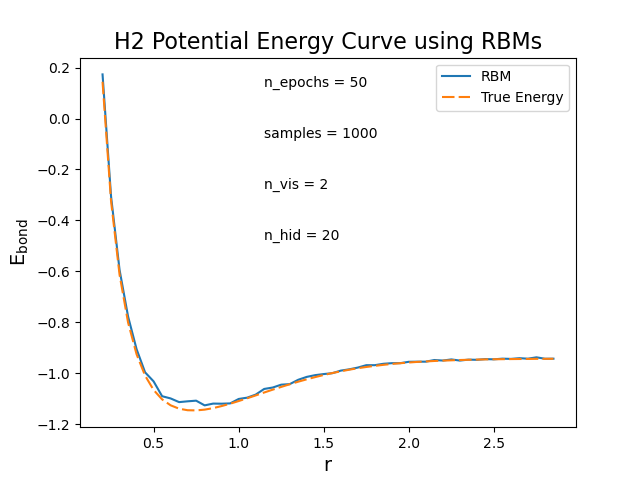

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#Define plots
rbm_plot = ax.plot(r, energiesList, label='RBM')
true_plot = ax.plot(r, true_energiesList, dashes=[6, 2], label='True Energy')

#Text formating
params = {'mathtext.default': 'regular' }  
plt.rcParams.update(params)
plt.xlabel('$r$', fontsize=14)
y = plt.ylabel('$E_{bond}$', fontsize=14)
plt.title('H2 Potential Energy Curve using RBMs', fontsize=16)
plt.text(r[-35], energiesList[0] - 0.05, "n_epochs = " + str(epochs))
plt.text(r[-35], energiesList[0] - 0.25, "samples = " + str(num_samples))
plt.text(r[-35], energiesList[0] - 0.45, "n_vis = " + str(n_vis))
plt.text(r[-35], energiesList[0] - 0.65, "n_hid = " + str(n_hin))

ax.legend()
plt.show()